# Avancement projet Anomalies, 2 avril

## Téléchargement des librairies

In [1]:
import pandas as pd
import numpy as np
import os
import pickle

#Fonctions statistiques 
import scipy.stats

# ACP
import sklearn.decomposition as sd
import sklearn.preprocessing as sp
# FFT
from scipy.fftpack import fft
# Hierarchical clustering
import scipy.cluster.hierarchy as sch
#Wavelet
import pywt
from pywt import wavedec
from statsmodels.robust import mad
# LOF
import sklearn.neighbors as sn
# Isolation Forest
import sklearn.ensemble as se
#One Class SVM
import sklearn.svm as ssvm

# Plot et Display
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sb
sb.set()
sb.set_style("darkgrid", {"axes.facecolor": ".9"})

# Interactive display
from ipywidgets import interact, widgets, interactive, fixed, interact_manual
from IPython.display import display

## Lecture des données

On lit directement les données nettoyées et dont la longueur a été modifiée à 1024.

In [2]:
import pickle
with open('X_1024', 'rb') as fichier:
    mon_depickler = pickle.Unpickler(fichier)
    X_1024, ind = mon_depickler.load() #X_1024 : données  #ind : liste des indices des signaux
n = len(X_1024) #nb de signaux
liste_appr = list(np.asarray(X_1024)[np.asarray(ind) <= 299])
liste_test = list(np.asarray(X_1024)[np.asarray(ind) > 299])

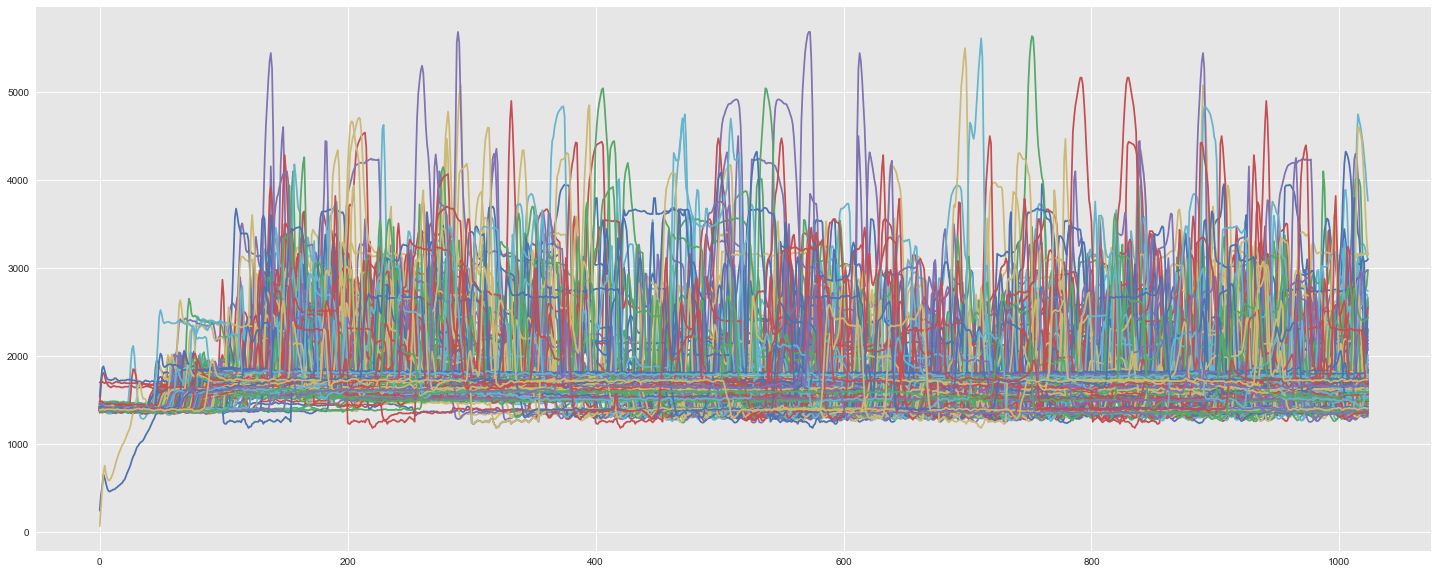

In [3]:
fig = plt.figure(figsize=(25, 10))
for x in X_1024:
    plt.plot(x)

# Coefficients de Fourier

In [4]:
fftCoeff = []

for x in X_1024 :
    mx = np.mean(x)
    x_centre = x - mx
    #Apply fast Fourier transform
    coeffsfft = np.abs(fft(x_centre))
    coeffsfft_flatten = np.hstack(coeffsfft)
    fftCoeff.append(coeffsfft_flatten)

fftCoeff = np.array(fftCoeff)
print(fftCoeff.shape)

#Coefficients seuillés
prop_a_garder = 0.1
nb_coeffs = int(fftCoeff.shape[1] * prop_a_garder)
somme = np.sum(fftCoeff**2, axis=0)
fftCoeff_seuil = np.zeros((0, nb_coeffs))
ind_grands = np.argsort(somme)[-nb_coeffs :]
fftCoeff_seuil = fftCoeff[:, ind_grands]

print(fftCoeff_seuil.shape)

(425, 1024)
(425, 102)


# Décomposition en ondelettes

On effectue la décomposition en ondelettes pour chaque signal et on récupère 2 tableaux de coefficients, l'un avec tous les coefficients de chaque signal, l'autre avec les coefficients seuillés. On pourra réaliser la décomposition en ondelettes seuillés avec les modes `hard`, `soft`, `greater` ou `less`.

In [5]:
wavelist=['haar','db2'] 
wf = 'haar' #Choix de l'ondelette

Coeff_ond = []
Coeff_ondT = []
for x in X_1024:
    #Apply wavelet decomposition
    coeffs = pywt.wavedec(x,wf,level=8) 
    coeffs_flatten = np.hstack(coeffs)
    Coeff_ond.append(coeffs_flatten)
    # Compute universal Threshold http://jseabold.net/blog/2012/02/23/wavelet-regression-in-python/
    sigma = mad(coeffs[-1])
    uthresh = sigma*np.sqrt(2*np.log(1024))
    # Apply Threshold on 4 first levels
    coeffs_thresh = [pywt.threshold(c, uthresh, mode="hard") if j<=3 else c for j,c in enumerate(coeffs[::-1])]
    coeffs_thresh_flatten = np.hstack(coeffs_thresh[::-1])
    Coeff_ondT.append(coeffs_thresh_flatten)
    
Coeff_ond = np.array(Coeff_ond)
Coeff_ondT = np.array(Coeff_ondT)
print(Coeff_ond.shape, Coeff_ondT.shape)
print(np.sum(Coeff_ond!=0), np.sum(Coeff_ondT!=0))

(425, 1024) (425, 1024)
304114 137127


#### Choix des coefficients d'ondelettes

In [6]:
#Coefficient de niveau 7 à 10:
Coeff_ond7=Coeff_ond[:,128:]
#Coefficient de niveau 1 à 6 : 
Coeff_ondA6=Coeff_ond[:,:128]
#Coefficient de niveau 1 à 4 : 
Coeff_ondA4=Coeff_ond[:,:16]

## Liste des différents coefficients sur lesquels appliquer les différentes méthodes

In [7]:
#Liste et dictionnaire des coefficients #Utile pour les fonctions interactives
Coeff_liste=["Tous les coefficients d'ondelettes",
             "Coefficients d'ondelettes, niveau 7",
             "Coefficients d'ondelettes, niveaux 1 à 6",
             "Coefficients d'ondelettes, niveau 1 à 4",
             "Coefficients d'ondelettes seuillés",
             "Coefficients de Fourier",
             "Coefficients de Fourier seuillés",
             "X_1024"]

dict_coeff ={"Tous les coefficients d'ondelettes" : Coeff_ond,
             "Coefficients d'ondelettes, niveau 7" : Coeff_ond7,
             "Coefficients d'ondelettes, niveaux 1 à 6" : Coeff_ondA6,
             "Coefficients d'ondelettes, niveau 1 à 4" : Coeff_ondA4, 
             "Coefficients d'ondelettes seuillés" : Coeff_ondT,
             "Coefficients de Fourier" : fftCoeff,
             "Coefficients de Fourier seuillés" : fftCoeff_seuil,
             "X_1024" : X_1024}

## Analyse en composantes principales

#### Fonctions d'affichage

In [8]:
def plot_var_ACP(X_acp, acp) :
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,2,1)
    ax.bar(range(10), acp.explained_variance_ratio_[:10]*100, align='center', color='grey', ecolor='black')
    ax.set_xticks(range(10))
    ax.set_ylabel("Variance")
    ax.set_title("Pourcentage de variance expliquée \n des premières composantes", fontsize=20)

    ax = fig.add_subplot(1,2,2)
    box = ax.boxplot(X_acp[:, 0:10])
    ax.set_title("Distribution des premières composantes", fontsize=20)
    plt.show()
    
def plot_proj_ACP(X_acp, axe_1=0, axe_2=1, etiq=True) :
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,1,1)
    dict_color = {True : "blue", False : "red"}

    for x, y, s in zip(X_acp[:,axe_1], X_acp[:,axe_2], ind) :
        ax.plot(x,y,marker=".", color=dict_color[s < 300]) #300 : longueur liste apprentissage
        if etiq :
            ax.text(x, y, str(s))
       
    ax.set_title("Projection des invididus sur les \n  deux premières composantes", fontsize=20)

    legend_elements = [Line2D([0], [0], marker='.', color='blue', label='Série du jeu d\'apprentissage', markersize=10, linewidth=0),
                       Line2D([0], [0], marker='.', color='red', label='Série du jeu de test', markersize=10, linewidth=0)]

    ax.legend(handles=legend_elements)

    plt.show()
    

#### Visualisation des résultats

In [9]:
@interact(Choix_coeff=Coeff_liste)
def ACP(Choix_coeff):
    Coeff=dict_coeff[Choix_coeff]
    acp = sd.PCA()
    X_acp = acp.fit_transform(sp.scale(Coeff))
    plot_var_ACP(X_acp, acp)
    plot_proj_ACP(X_acp, axe_1=0, axe_2=1)

interactive(children=(Dropdown(description='Choix_coeff', options=("Tous les coefficients d'ondelettes", "Coef…

## Classification ascendante hierarchique

#### Fonction d'affichage

In [10]:
def plot_dendrogram(Z,p):
    fig = plt.figure(figsize=(25, 10))
    sch.dendrogram(Z, p, leaf_rotation=45.,leaf_font_size=15, truncate_mode="level", labels=ind)  # font size for the x axis labels
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    plt.show()

#### Visualisation des résultats

In [11]:
@interact(Choix_coeff=Coeff_liste,p=widgets.IntSlider(min=1,max=50,step=1,value=20,continuous_update=False))
def CAH(Choix_coeff,p):
    Coeff=dict_coeff[Choix_coeff]
    Z = sch.linkage(Coeff, 'single')
    C = np.array([c[0] for c in sch.cut_tree(Z,5)])
    CT = pd.DataFrame(list(C), columns=["HCA_cluster"])
    plot_dendrogram(Z,p)
    

interactive(children=(Dropdown(description='Choix_coeff', options=("Tous les coefficients d'ondelettes", "Coef…

### Fonction d'affichage des anomalies

In [12]:
def print_anomalies(ind_anomalies,ind_data = ind):
    """Permet d'afficher le bon indice de la série dans le cas où des series ont été supprimées du jeu de données"""
    return [ind_data[i] for i in ind_anomalies]

## Isolation Forest

#### Visualisation des résultats

In [13]:
contamination=20/n
n_estimators=100

@interact(Choix_coeff=Coeff_liste)
def plot_IF_anomaly(Choix_coeff):
    Coeff=dict_coeff[Choix_coeff]
    
    clf = se.IsolationForest(n_estimators=n_estimators, contamination=contamination, bootstrap=True, n_jobs=-1)
    clf.fit(Coeff)
    pred = clf.predict(Coeff)
    
    acp_ond = sd.PCA()
    X_acp_ond = acp_ond.fit_transform(sp.scale(Coeff))
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,1,1)
    for i, j, nom, s in zip(X_acp_ond[:,0], X_acp_ond[:,1], pred, ind):
        color = "red" if nom!=1  else "grey"
        plt.plot(i, j, "o",color=color) 
        if nom!=1:
            ax.text(i,j,str(s))
    ax.set_title("Repésentation des atypiques sur la projection des 2 premières composantes de l'ACP", fontsize=20)
    plt.show()
    
    print("Anomalies détectées: ", print_anomalies([i for i,x in enumerate(pred) if x!=1]))

interactive(children=(Dropdown(description='Choix_coeff', options=("Tous les coefficients d'ondelettes", "Coef…

## One Class SVM

#### Visualisation des résultats

In [14]:
kernel="rbf"
#nu=30/len(liste_appr) # Pourcentage estimé d'outliers dans le jeu d'apprentissage
gamma=1e-11

@interact(Choix_coeff=Coeff_liste,nu=widgets.FloatSlider(min=0.01,max=1.0,step=0.01,value=0.05))
def plot_OCSVM_anomaly(Choix_coeff,nu):
    Coeff=dict_coeff[Choix_coeff]
    
    OCS = ssvm.OneClassSVM(kernel=kernel,nu=nu,gamma=gamma)
    OCS.fit(Coeff)
    pred = OCS.predict(Coeff)
    
    acp_ond = sd.PCA()
    X_acp_ond = acp_ond.fit_transform(sp.scale(Coeff))
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,1,1)
    for i, j, nom, s in zip(X_acp_ond[:,0], X_acp_ond[:,1], pred, ind):
        color = "red" if nom!=1  else "grey"
        plt.plot(i, j, "o",color=color) 
        if nom!=1:
            ax.text(i,j,str(s))
    ax.set_title("Repésentation des atypiques sur la projection des 2 premières composantes de l'ACP", fontsize=20)
    plt.show()
    
    print("Anomalies détectées : ", print_anomalies([i for i,x in enumerate(pred) if x!=1]))

interactive(children=(Dropdown(description='Choix_coeff', options=("Tous les coefficients d'ondelettes", "Coef…

## Local Outlier Factor

#### Visualisation des résultats

In [15]:
contamination=20/n
metric = "euclidean"
#n_neighbors = 15

@interact(Choix_coeff=Coeff_liste,n_neighbors=widgets.IntSlider(min=1,max=30,step=1,value=15))
def plot_LOF_anomaly(Choix_coeff,n_neighbors):
    Coeff=dict_coeff[Choix_coeff]
    
    clf = sn.LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, metric=metric)
    pred = list(clf.fit_predict(Coeff))
    
    acp_ond = sd.PCA()
    X_acp_ond = acp_ond.fit_transform(sp.scale(Coeff))
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,1,1)
    for i, j, nom, s in zip(X_acp_ond[:,0], X_acp_ond[:,1], pred, ind):
        color = "red" if nom!=1  else "grey"
        plt.plot(i, j, "o",color=color) 
        if nom!=1:
            ax.text(i,j,str(s))
    ax.set_title("Repésentation des atypiques sur la projection des 2 premières composantes de l'ACP", fontsize=20)
    plt.show()
    
    print("Anomalies détectées : ", print_anomalies([i for i,x in enumerate(pred) if x!=1]))

interactive(children=(Dropdown(description='Choix_coeff', options=("Tous les coefficients d'ondelettes", "Coef…

## Comparaison des méthodes IF, OC-SVM et LOF

In [16]:
methode_liste = ["Isolation Forest", "One-Class SVM", "Local Outlier Factor"]
contamination = 20/n #IF, LOF
n_neighbors = 15 #LOF
nu = 0.05 #OC-SVM
gamma= 1e-11#OC-SVM

#A CONSERVER : peut etre utile pour faire le choix des parametres
def f(**args):
    return args

@interact(Choix_coeff=Coeff_liste, methode=methode_liste)
def plot_anomaly(Choix_coeff, methode):
    Coeff=dict_coeff[Choix_coeff]
    
    if methode=="Local Outlier Factor":
        clf = sn.LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, metric="euclidean")
        pred = clf.fit_predict(Coeff)
    elif methode=="Isolation Forest":
        clf = se.IsolationForest(n_estimators=n_estimators, contamination=contamination, bootstrap=True, n_jobs=-1)
        clf.fit(Coeff)
        pred = clf.predict(Coeff)
    elif methode=="One-Class SVM":
        OCS = ssvm.OneClassSVM(kernel=kernel,nu=nu,gamma=gamma)
        OCS.fit(Coeff)
        pred = OCS.predict(Coeff)
        
        
    acp_ond = sd.PCA()
    X_acp_ond = acp_ond.fit_transform(sp.scale(Coeff))
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,1,1)
    for i, j, nom, s in zip(X_acp_ond[:,0], X_acp_ond[:,1], pred, ind):
        color = "red" if nom!=1  else "grey"
        plt.plot(i, j, "o",color=color) 
        if nom!=1:
            ax.text(i,j,str(s))
    plt.show()
    
    print("Anomalies détectées : ", print_anomalies([i for i,x in enumerate(pred) if x!=1]))

interactive(children=(Dropdown(description='Choix_coeff', options=("Tous les coefficients d'ondelettes", "Coef…

# Features

## Liste des features  

- min, max
- mean 
- écart type 
- Skewness 
- Kurtosis 
- Energy 
- Average Crossing 

A ajouter ?

- Distribution spectrale d'énergie 
- Pourcentage d'extrema locaux 

https://arc.aiaa.org/doi/pdf/10.2514/6.2016-2430

In [18]:
with open('liste_propre', 'rb') as fichier:
    mon_depickler = pickle.Unpickler(fichier)
    liste_comp, ind = mon_depickler.load() #liste_comp : données  #ind : liste des indices des signaux
n = len(liste_comp) #nb de signaux
liste_appr = list(np.asarray(liste_comp)[np.asarray(ind) <= 299])
liste_test = list(np.asarray(liste_comp)[np.asarray(ind) > 299])

In [19]:
listeMin = [min(liste) for liste in liste_comp]
listeMax = [max(liste) for liste in liste_comp]
listeMean = [np.mean(liste) for liste in liste_comp]
listeStd = [np.std(liste) for liste in liste_comp]
listeSkewness = [scipy.stats.skew(liste) for liste in liste_comp]
listeKurtosis = [scipy.stats.kurtosis(liste) for liste in liste_comp]
listeEnergy = [sum(np.asarray(liste)**2)/len(liste) for liste in liste_comp]
listeAverageCross = [sum(1*(liste > np.mean(liste)))/len(liste) for liste in liste_comp]

### Construction de la DataBase

In [21]:
dico = {"Min": listeMin, "Max": listeMax, "Moyenne": listeMean, "Ecart-type": listeStd, "Skewness" : listeSkewness, "Kurtosis": listeKurtosis, "Energie": listeEnergy, "Average_Crossing": listeAverageCross}
DataFeatures = pd.DataFrame(dico)

In [22]:
DataFeatures.head()

,Min,Max,Moyenne,Ecart-type,Skewness,Kurtosis,Energie,Average_Crossing
0,1280.0,3552.0,1734.202643,345.126677,2.711380,9.500535,3.126571e+06,0.182085
1,1296.0,3320.0,1693.226667,295.348143,1.808988,5.835758,2.954247e+06,0.413333
2,1280.0,3392.0,1654.509434,187.856340,4.883878,40.924481,2.772691e+06,0.849057
3,1288.0,3208.0,1616.614610,225.503825,3.493780,21.057169,2.664295e+06,0.716625
4,1296.0,2328.0,1607.755258,183.891068,0.834251,2.440176,2.618693e+06,0.684512


In [23]:
DataFeatures.describe()

,Min,Max,Moyenne,Ecart-type,Skewness,Kurtosis,Energie,Average_Crossing
count,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,4.250000e+02,425.000000
mean,1304.512941,3052.385882,1662.325406,257.244272,2.005907,10.484788,2.851309e+06,0.503975
std,87.455490,822.272898,78.989406,124.984507,1.844992,10.724655,3.271909e+05,0.230426
min,72.000000,1624.000000,1457.300813,53.978124,-2.870609,-1.826071,2.149992e+06,0.056159
25%,1288.000000,2456.000000,1608.691176,158.366617,1.005085,2.938023,2.627719e+06,0.261808
50%,1304.000000,2968.000000,1647.570662,225.503825,2.208380,7.680911,2.771719e+06,0.593176
75%,1320.000000,3504.000000,1713.142857,311.067269,3.223703,14.507249,3.028428e+06,0.692868
max,1464.000000,5984.000000,1910.453608,860.538894,6.964047,58.596857,4.117989e+06,0.861538


In [44]:
data_train = DataFeatures.iloc[: len(liste_appr), :]
data_test = DataFeatures.iloc[len(liste_appr) :, :]
data_test.describe()

,Min,Max,Moyenne,Ecart-type,Skewness,Kurtosis,Energie,Average_Crossing
count,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,1.280000e+02,128.000000
mean,1312.140625,3041.000000,1681.131871,256.957453,1.832478,10.296867,2.916155e+06,0.501287
std,119.882931,836.939306,87.738878,128.116474,2.059130,12.165659,3.564267e+05,0.235063
min,72.000000,1624.000000,1524.917609,57.801247,-2.870609,-1.763901,2.362471e+06,0.070284
25%,1302.000000,2458.000000,1613.451399,159.614775,0.145547,2.287839,2.650776e+06,0.235914
50%,1320.000000,2940.000000,1658.573002,216.153077,1.883105,6.979544,2.811549e+06,0.600456
75%,1354.000000,3570.000000,1752.847804,303.359617,3.154531,13.219379,3.138162e+06,0.699531
max,1432.000000,5616.000000,1894.520301,703.874510,6.964047,58.596857,4.084646e+06,0.861538


## ACP 

In [25]:
pca = sd.PCA()
data = DataFeatures[["Min","Max","Moyenne","Ecart-type","Skewness","Kurtosis","Energie", "Average_Crossing"]]
C = pca.fit_transform(sp.scale(data))

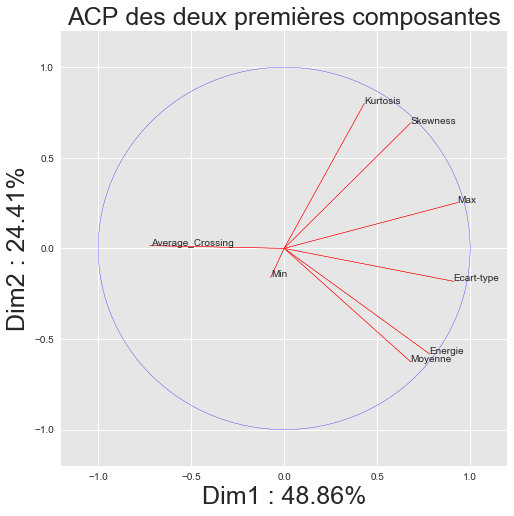

In [26]:
# coordonnées des variables
coord1=pca.components_[0]*np.sqrt(pca.explained_variance_[0])
coord2=pca.components_[1]*np.sqrt(pca.explained_variance_[1])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
for i, j, nom in zip(coord1,coord2, data.columns):
    plt.text(i, j, nom)
    plt.arrow(0,0,i,j,color='r')
plt.axis((-1.2,1.2,-1.2,1.2))
# cercle
c=plt.Circle((0,0), radius=1, color='b', fill=False)
ax.add_patch(c)
ax.set_xlabel("Dim1 : " + str(round(pca.explained_variance_ratio_[:10][0]*100,2))+ "%" ,size=25)
ax.set_ylabel("Dim2 : " + str(round(pca.explained_variance_ratio_[:10][1]*100,2)) + "%",size=25)
ax.set_title("ACP des deux premières composantes",size=25)
plt.show()

In [54]:
def plot_var_ACP(X_acp) :
    acp = sd.PCA()
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(1,2,1)
    ax.bar(range(5), acp.explained_variance_ratio_[:5]*100, align='center', color='grey', ecolor='black')
    ax.set_xticks(range(10))
    ax.set_ylabel("Variance")
    ax.set_title("Pourcentage de variance expliquée \n des premières composantes", fontsize=20)

    ax = fig.add_subplot(1,2,2)
    box = ax.boxplot(X_acp[:, 0:10])
    ax.set_title("Distribution des premières composantes", fontsize=20)
    plt.show()
    
def plot_proj_ACP(X_acp, axe_1=0, axe_2=1, etiq=True) :
    acp = sd.PCA()
    fig = plt.figure(figsize=(13,8))
    ax = fig.add_subplot(1,1,1)
    dict_color = {True : "blue", False : "red"}

    for x, y, s in zip(X_acp[:,axe_1], X_acp[:,axe_2], range(len(liste_comp))) :
        ax.plot(x,y,marker=".", color=dict_color[s < len(liste_appr)])
        if etiq :
            ax.text(x, y, str(s))
       
    ax.set_title("Projection des invididus sur les \n  deux premières composantes", fontsize=20)

    legend_elements = [Line2D([0], [0], marker='.', color='blue', label='Série du jeu d\'apprentissage', markersize=10, linewidth=0),
                       Line2D([0], [0], marker='.', color='red', label='Série du jeu de test', markersize=10, linewidth=0)]

    ax.legend(handles=legend_elements)

    plt.show()

In [55]:
len(liste_appr)

297

In [61]:
plot_var_ACP(pca)

TypeError: plot_var_ACP() missing 1 required positional argument: 'pca'

## CAH 

In [33]:
def plot_dendro(Z) :
    fig = plt.figure(figsize=(25, 10))
    sch.dendrogram(Z, p=10, leaf_rotation=45., leaf_font_size=15, truncate_mode="level")  # font size for the x axis labels

    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    plt.show()
    

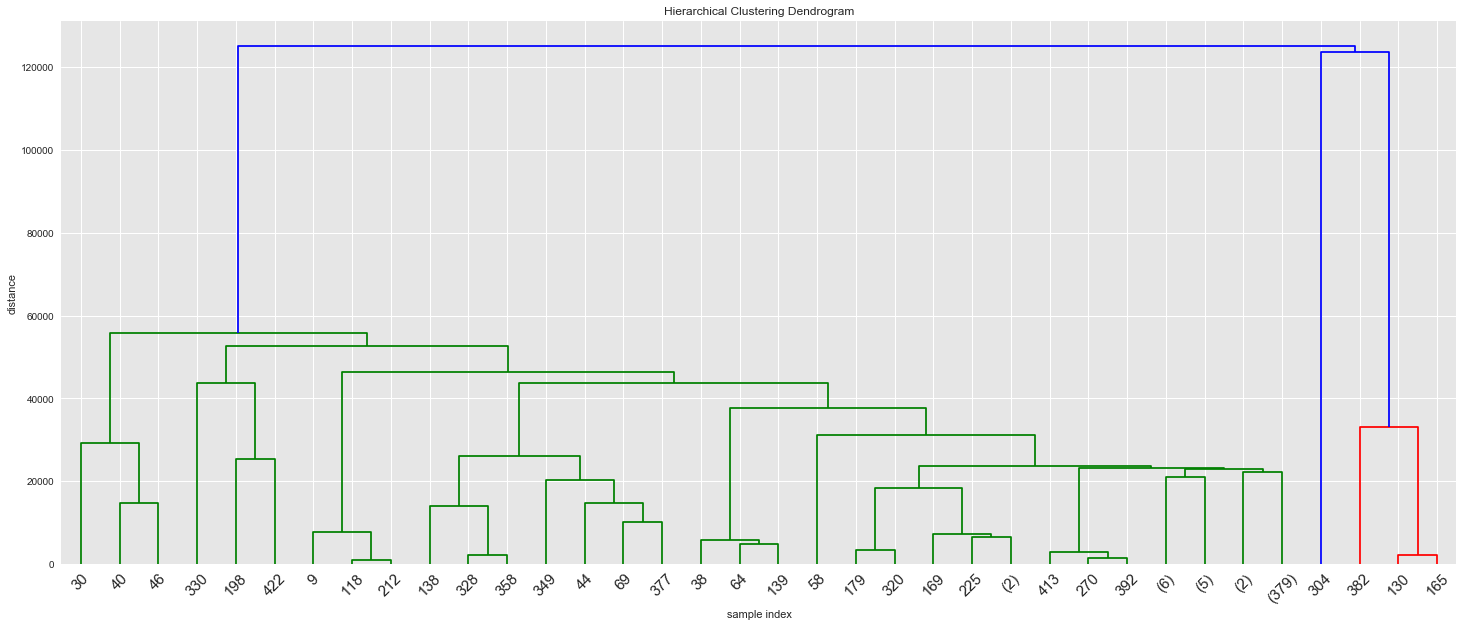

In [34]:
Z = sch.linkage(DataFeatures, 'single')
plot_dendro(Z)

array([[     0.        ,  14860.7137244 ,  14860.7137244 ,
             0.        ],
       [     0.        ,  29281.74830109,  29281.74830109,
         14860.7137244 ],
       [     0.        ,  25495.82576492,  25495.82576492,
             0.        ],
       ...,
       [     0.        ,  33070.07936304,  33070.07936304,
          2181.35187439],
       [     0.        , 123527.402694  , 123527.402694  ,
         33070.07936304],
       [ 55900.56788092, 124937.20749086, 124937.20749086,
        123527.402694  ]])

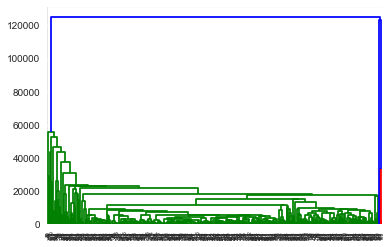

In [35]:
np.array(sch.dendrogram(Z)["dcoord"])

[30, 40, 46, 330, 198, 422, 9, 118, 212, 138]


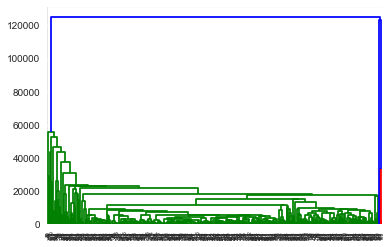

In [36]:
print(list(sch.dendrogram(Z)["leaves"])[:10])

## Isolation Forest

In [50]:
clf = se.IsolationForest(n_estimators=100, contamination=20/428, bootstrap=True, n_jobs=-1)
clf.fit(DataFeatures)
y_pred = clf.predict(DataFeatures)

CT_IF = pd.DataFrame(list(y_pred), columns=["pred"]) 

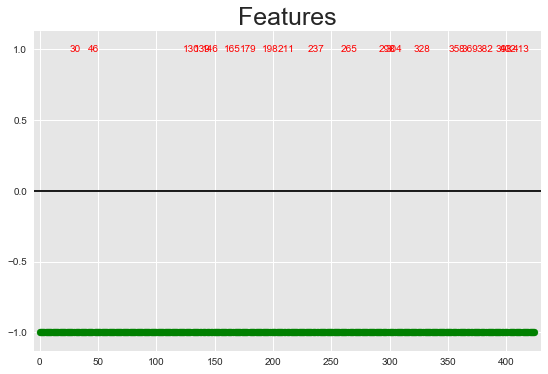

In [51]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(3,2,1)
plot_result_IF(fig, ax, CT_IF, title="Features", fontsize=25)

In [52]:
print("Anomalies : ", CT_IF[CT_IF.pred == -1].index.values)

Anomalies :  [ 30  46 130 139 146 165 179 198 211 237 265 298 304 328 358 369 382 398
 402 413]


## OC-SVM 

### Calibration du paramètre nu par recherche dichotomique

In [45]:
outlier_prop = 30 / 297  # Pourcentage estimé d'outliers dans le jeu d'apprentissage
a = 1.e-13
b = 1
gamma = (a + b) / 2
niter = 0
OCSVM = OneClassSVM(kernel='rbf', nu=outlier_prop, gamma=gamma)
y_pred = OCSVM.fit(data_train).predict(data_test)
nb_out = np.asarray(y_pred)[np.asarray(y_pred) == 1].shape[0]
while nb_out != 20 and niter < 1e3:
    if nb_out < 20 :
        b = gamma
    else :
        a = gamma
    gamma = (a + b) / 2
    OCSVM = OneClassSVM(kernel='rbf', nu=outlier_prop, gamma=gamma)
    y_pred = OCSVM.fit(data_train).predict(data_test)
    nb_out = np.asarray(y_pred)[np.asarray(y_pred) == 1].shape[0]
    niter += 1
print(gamma)

8.9407067163077e-08


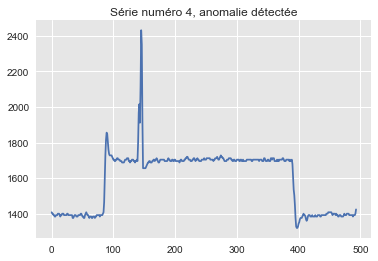

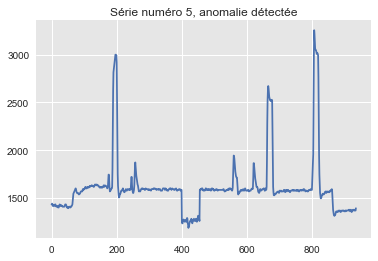

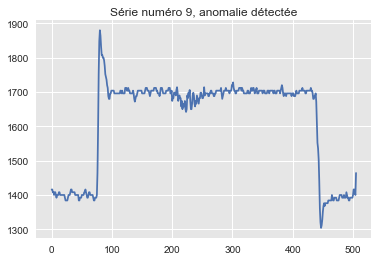

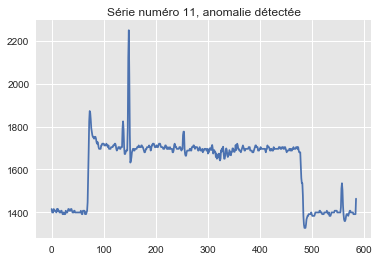

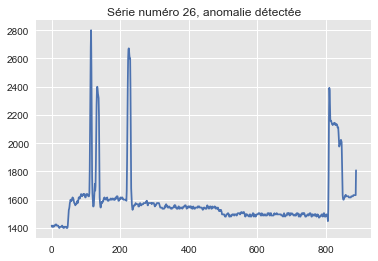

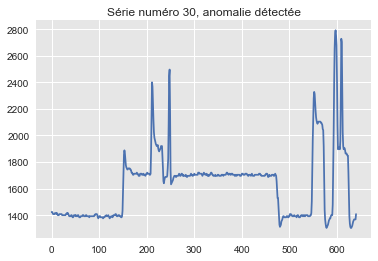

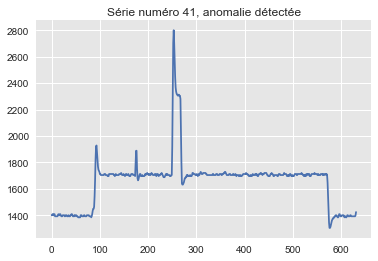

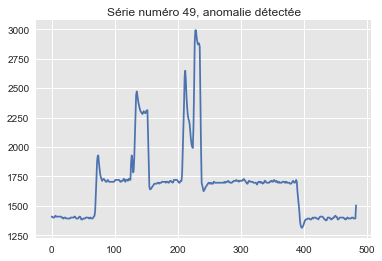

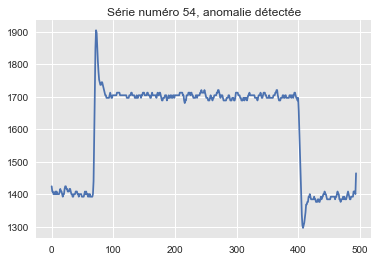

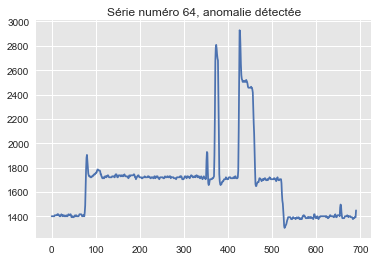

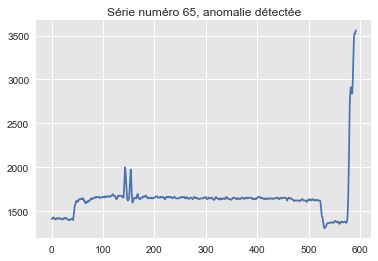

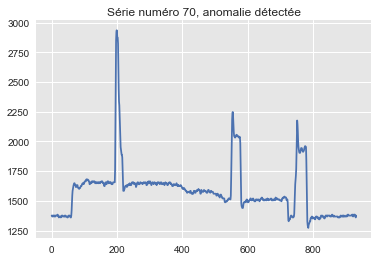

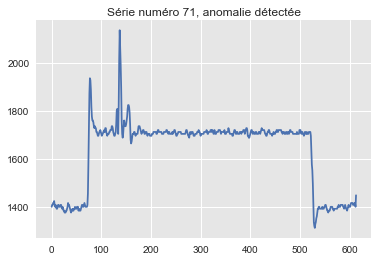

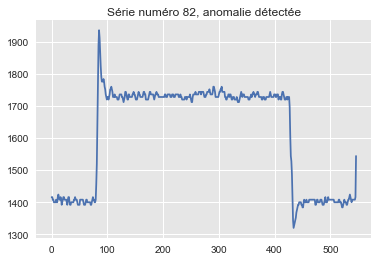

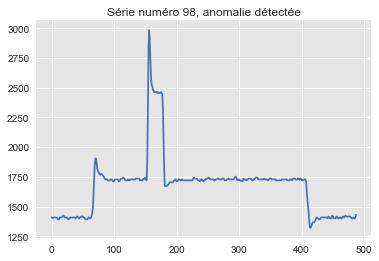

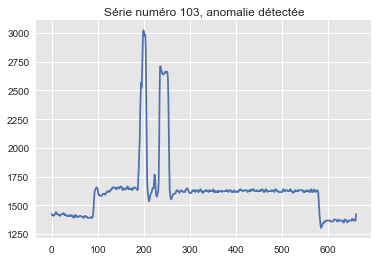

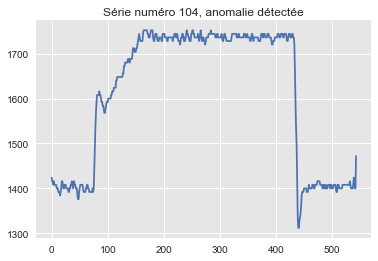

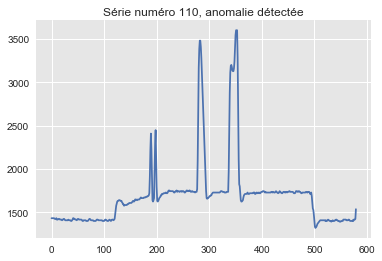

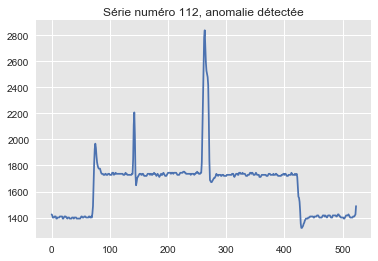

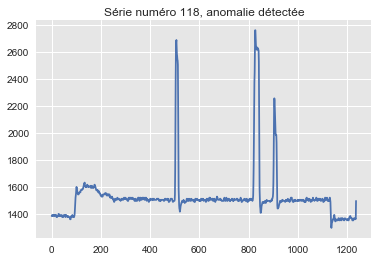

[304, 305, 309, 311, 326, 330, 341, 349, 354, 364, 365, 370, 371, 382, 398, 403, 404, 410, 412, 418]


In [46]:
OCSVM = OneClassSVM(kernel='rbf', nu=outlier_prop, gamma=gamma)
y_pred = OCSVM.fit(data_train).predict(data_test)
anom = []
for i, serie in enumerate(liste_test):
    if y_pred[i] == 1:
        anom.append(300 + i)
        plt.plot(serie)
        plt.title("Série numéro " + str(i) + ", anomalie détectée")
        plt.show()
    elif False:
        plt.plot(serie)
        plt.title("Série numéro " + str(i))
        plt.show()
print(anom)